# `OscaRobber`

# Part II: Network analysis

We will perform a network analysis on the network of ***science fiction movies***. We decided to focus on one specific genre rather than to work on the entire network, as the amount of nodes and links becomes too huge and we would have to limit the number of actors acted in one movie to somewhat like 5 in order to maintain a good performance. Basically, every genre can be analyzed with infrastructure built below, which is created in a very beautiful manner. For example, to analyze network of horror films, only one variable has to be changed (check it out, `genre_id = 8`).

## Helpers

Helpers are classes with logic for performing/supporting analysis tasks. Apart from classes `Table` and `MongoHelper` developed earlier in this project, we define an additional class `NetXHelper`, which contains every piece of code needed to produce beautiful graphs and perform everything from assortativity analysis to community detection. By encapsulating (almost) complete logic to a class, we free up a lot of space in this notebook to show comprehensive information on results, as this is not a coding class and we care mostly about content and analysis.

### Table

In [1]:
from lib.table import Table

### MongoDB helper

In [2]:
from lib.mongohelper import MongoHelper
mongo = MongoHelper('imdb')

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'imdb')


### NetworkX helper

In [3]:
from lib.networkhelper import NetworkHelper
net = NetworkHelper()

### Other libraries

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import re
import random

## Bipartite network

### Network representation

In order to represent any network, it is necessary to characterize the properties of the corresponding graph of nodes and links. The collaboration graph of movies and actors is called co-stardom network. The co-stardom network will be represented by a bipartite graph $Bip$ where nodes are of two types: actors and movies. Bipartite graph $Bip=(M,A,E)$ will have two node sets $M$, $A$ and edges in $E$ that only connect nodes from opposite sets. One set of nodes will correspond to movies ($M$) and the other to actors ($A$). $M$ is connected to $A$ if $A$ has played in $M$. Hence there are no direct $M$-$M$ or $A$-$A$ links. The network is undirected to enable certain analysis tools to be applied (which aren't capable of running on directed graphs, like `bipartite.projected_graph(G, nodes)`).

### Data format

As the amount of nodes is huge, we must think of using a right data format to save space in memory. We know that integers take less place than strings, hence our first idea is using original ids, e.g., `movie_id` or `person_id`. But here the first problem arises: ids of both movies and persons are integers, and thus indifferent for NetworkX. Using strings is space consuming, so we end up using integers but with different signs: minus sign for `person_id`, plus sign for `movie_id`.

### Populate network

There are 28 different genres recognized by IMDB, and we have full power of choosing whatever genre we basically want. As the mount of actor nodes growth rapidly with the amount of movie nodes (there are movies with really MANY actors), let us decide on a genre with of a medium size.

In [5]:
tab = Table()
tab.from_tuples([
        (genre_id, 
         genre[0], 
         len(mongo.collect('genres', filter={'info': genre_id}))) 
        for genre_id, genre in mongo.collect('genres_map').iteritems()
    ], columns=['Genre id', 'Genre', 'Movies'])
tab.sort_values(by='Movies', ascending=False)
tab.display()


    Genre id        Genre  Movies
16        16        Short  526364
18        18        Drama  300712
6          6       Comedy  196345
20        20  Documentary  159065
13        13     Thriller   59223
2          2      Romance   58873
19        19       Action   50377
8          8       Horror   44677
3          3    Animation   42046
1          1        Crime   36431
23        23       Family   34344
24        24      Fantasy   29423
10        10    Adventure   28652
15        15      Mystery   25658
0          0       Sci-Fi   24817
4          4        Music   21524
27        27    Biography   20340
22        22      History   17379
14        14      Western   14274
21        21      Musical   13947
7          7          War   13836
26        26        Sport   10141
5          5        Adult    8239
11        11         News    8021
9          9    Film-Noir     728
12        12   Reality-TV     288
17        17    Talk-Show     153
25        25    Game-Show      57



We decided to pick up sci-fi movies. 

***Notice: the analysis can be done on other genre just by changing this single variable.***

In [6]:
genre_id = 0 # sci-fi

In [7]:
movie_ids = mongo.collect('genres', filter={'info': genre_id}).keys()

We are happy to have done the data preparation in the way that further fetching of data is simple and intuitive. Our network is populated basically with 1 single MongoDB collection called `cast`. In this collection, list of `person_id` is keyed by `movie_id`, and that's our future edges. So in the first step, we "unwind" each `person_id` list to list of tuples consisting of `-person_id` and `movie_id` (minus, as stated above, is required to distinguish between id of movies and persons which exist in the same integer space). 

Apart from edges, we have to feed our network with top and bottom nodes. Nodes alone are already present in the network by calling `G.add_edges_from(edges)`, but `networkx` is not capable to identify which of them are top nodes, and which bottom nodes (except that bottom nodes, i.e. `-person_id`, have a minus sign prior to their ids). NetworkX does not have a custom bipartite graph class so the Graph() class is used to represent a bipartite graph. However, we must keep track of which set each node belongs to, and make sure that there is no edge between nodes of the same set. We use the rule (which is the convention in NetworkX) of attaching an attribute named `bipartite` with values 0 or 1 to identify the sets each node belongs to. Nodes with `bipartite=0` correspond to bottom nodes, nodes with `bipartite=1` to top nodes respectively.

In [8]:
tab = Table()
edges = [
    (-person_id, movie_id)
    for movie_id, person_ids in mongo.collect('cast', filter={'id': {'$in': movie_ids}}).iteritems()
    for person_id in person_ids
]
movie_ids = None
ntop = sorted(set([movie_id for _, movie_id in edges]))
nbottom = sorted(set([person_id for person_id, _ in edges]))
tab.from_tuples([(len(ntop), len(nbottom), len(edges))], columns=['Movies', 'Actors', 'Cast'])
tab.display()


   Movies  Actors    Cast
0   21381  205774  273936



While analysis of the entire network is very interesting, it may be more fun to discover certain areas of the network which are of the main interest to the user. To discover a certain area, we need to specify a root node `root` and the depth of traversal `depth`. The algorithm then, starting from the root node, runs the breadth-first search (BFS) on the largest undirected giant connected component (GCC); it counts number of visited levels `lvl` and returns a subgraph of the network if `depth` is reached. If no `root` but `depth` is passed, the algorithm selects a random node. If neither `root` nor `depth` are passed, then algorithm returns GCC. GCC is required to run all analysis tools on the network data without thinking much about its connectivity.

The root node of $Bip$ is a `movie_id` (although it could also be `person_id`, see below). Next method searches for a `movie_id` of a certain title and release year. A root node is a starting node for traversing a network which certain area needs to be discovered. 

In [9]:
def movie_id(title, release_year):
    '''Return movie_id by title and release year'''
    ids_by_year = [d['id'] for d in mongo.db.release_years.find({'info': release_year})]
    movie_ids = [d['id'] for d in mongo.db.titles_map.find({'id': {'$in': ids_by_year}, 'info': {'$regex': '.*%s.*'%title}})]
    if movie_ids:
        print ', '.join(map(str, movie_ids))
        return next(iter(movie_ids or []), None)
    else:
        None

In [10]:
root_movie = movie_id('Ghost in the Shell', 2017)
root_movie

3105146


3105146

To give you an opportunity to discover actors, we include the code that searches for a `person_id` based on his name and birth year.

In [11]:
def person_id(name, birth_year):
    '''Return person_id by name and birth year'''
    ids_by_year = [d['id'] for d in mongo.db.birth_years.find({'info': birth_year})]
    person_ids = [d['id'] for d in mongo.db.names_map.find({'id': {'$in': ids_by_year}, 'info': {'$regex': '.*%s.*'%name}})]
    if person_ids:
        print ', '.join(map(str, person_ids))
        return next(iter(person_ids or []), None)
    else:
        None

In [12]:
root_actor = person_id('Johansson, Scarlett', 1984)
root_actor

3059865


3059865

Method `BipGraph` takes network data and builds a NetworkX graph. We will not clean the data obtained from MongoDB yet, as we will need it to feed the directed version of the graph later.

In [13]:
Bip = net.BipGraph(nbottom, ntop, edges)


        N       L  Components  Larg. component    C         p  k_min  k_max  \
0  227155  273936        6594           186639  0.0  0.000011      1    448   

   k_median    k_mean  Time (sec)  
0       1.0  2.411886    2.668861  



The network of sci-fi movies consists of 227,155 nodes (movies+actors) and 273,936 links (cast). The giant connected component consists of 186,639 nodes (which is 82%). Probability of a link between two random nodes is very low, as network is bipartite, and actors, as well as movies, do not link to each other. minimum degree is 1 - every movie has at least one actor, every actor acted in at least one movie. Maximal degree is 448. This is ether degree of an actor node or of a movie node. We will dive into the details of degree distribution later. 

Now we are to filter some non-important movies and actors, and reduce the number of connected components to 1, i.e., extract the GCC. Applying analysis on GCC is more than sufficient, because pictures and figures of every major film industry (e.g., USA, UK, India) will belong to this component. Method `NetXHelper.network_area` does the job. It extracts an user-defined area from the graph. If `depth` and `root` are specified, the algorithm searches for the root and returns a subgraph with `depth` levels of nodes connected to the root. If graph is disconnected, it extracts the GCC. Reducing area of discovery at this stage of analysis would be counterproductive and simply to early, hence now we don't specify `depth` and `root` arguments and query for a GCC of the entire network. 

In [14]:
Bip = net.network_area(Bip)


        N       L  Components  Larg. component    C         p  k_min  k_max  \
0  186639  239412           1           186639  0.0  0.000014      1    448   

   k_median    k_mean  Time (sec)  
0       1.0  2.565509    9.020288  



Every statistic is almost the same as for the entire graph. Let's see how the graph looks like by drawing a subgraph. For this, we call the `NetXHelper.draw_graph_attr` method. What it does is basically extracting a subgraph based on 1) only nodes with attribute values specified as keys in `vcmap`, and 2) parameters `depth` and `root`. It passes those parameters to the method `NetXHelper.network_area` mentioned before, and draws this subgraph with respect to attributes attached to the nodes. Size of a node (as its color) on the plot is proportional to its degree relative to maximal degree among nodes of the same attribute value. Link between nodes of the same attribute value is colored with color of the least connected (of minimum degree) node among them. Link between nodes of different attribute values (like between top and bottom nodes) is colored with gray. We will apply colormap `plt.cm.winter` (green) on bottom nodes and `plt.cm.winter_r` (reversed of `plt.cm.winter`, blue) on top nodes. As root we will use the root obtained before (*Ghost in the Shell, 2017*). 

But let us first see how `depth` parameter works by drawing graphs with `depth=1` and `depth=2`.

Network of 1-level-neighbors from the root. 


    N   L  Components  Larg. component    C         p  k_min  k_max  k_median  \
0  26  25           1               26  0.0  0.076923      1     25       1.0   

     k_mean  Time (sec)  
0  1.923077    0.389098  

Attribute values: 0, 1


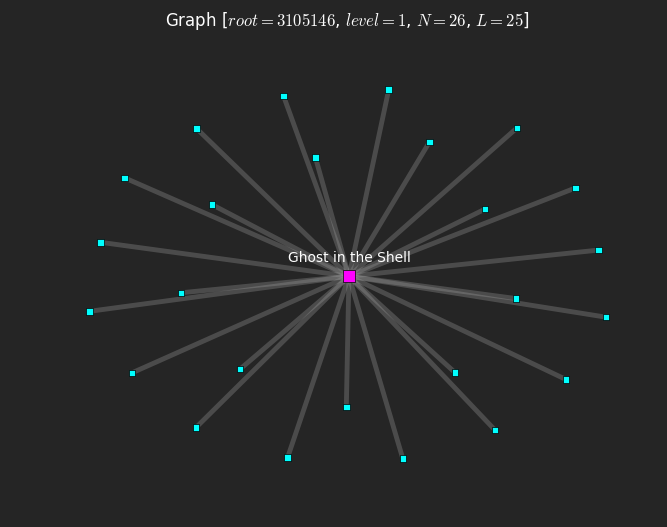

In [15]:
net.draw_graph_attr(
    Bip, 
    'bipartite', 
    {0: plt.cm.cool_r, 1: plt.cm.spring_r},
    depth=1, 
    root=root_movie,
    nlabels={1: 1},
    mongo=mongo,
    labelsmap={'names_map': lambda x: x<0, 'titles_map': lambda x: x>=0}
)

We see network of 6 nodes which represents first level of actors from the root movie. 

Network of 2-level-neighbors from the root. 


    N   L  Components  Larg. component    C         p  k_min  k_max  k_median  \
0  63  65           1               63  0.0  0.033282      1     25       1.0   

     k_mean  Time (sec)  
0  2.063492    0.504939  

Attribute values: 0, 1


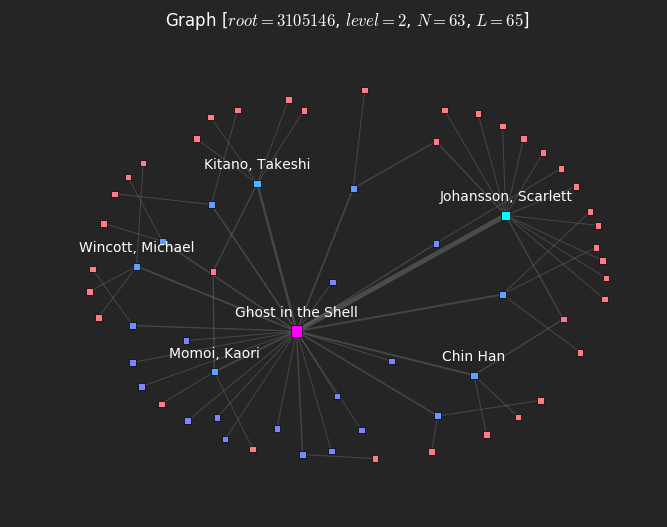

In [16]:
net.draw_graph_attr(
    Bip, 
    'bipartite', 
    {0: plt.cm.cool_r, 1: plt.cm.spring_r},
    depth=2, 
    root=root_movie,
    nlabels={0: 5, 1: 1},
    mongo=mongo,
    labelsmap={'names_map': lambda x: x<0, 'titles_map': lambda x: x>=0}
)

Plot shows 2 levels of nodes connected to the root. First level shows actors connected to the root movie, second level shows movies connected to the actors of the first level. ***This is an amazing property of bipartite networks: each level contains links only to the opposite set of nodes***. Among 148 nodes extracted by `NetXHelper.network_area` method there are 5 hubs with attribute `bipartite=0` (actors) and 1 hub with attribute `bipartite=1` (movies). The central movie is *Ghost in the Shell (2017)*, which isn't suprising, as traversal of the graph starts at this movie. Bottom hubs are the top 5 actors acted in this movie.

The number of levels (depth of the network) and the amount of nodes on each of them are returned by the method `NetXHelper.levels`.

In [17]:
depth_Bip = net.depth(Bip, root=root_movie)


    Level  Nodes   Visited  Time (sec)
0       0      1  0.000005    0.000040
1       1     25  0.000139    0.000105
2       2     37  0.000338    0.000207
3       3   2506  0.013765    0.008497
4       4   1669  0.022707    0.015173
5       5  46370  0.271154    0.411918
6       6   6595  0.306490    0.128759
7       7  83397  0.753326    0.784801
8       8   4214  0.775904    0.206533
9       9  31665  0.945563    0.132933
10     10   1166  0.951811    0.065919
11     11   6846  0.988491    0.258983
12     12    225  0.989697    0.013937
13     13   1287  0.996592    0.005884
14     14     44  0.996828    0.002467
15     15    314  0.998510    0.001071
16     16     22  0.998628    0.000618
17     17    135  0.999352    0.000499
18     18      9  0.999400    0.000350
19     19     60  0.999721    0.000462
20     20      5  0.999748    0.000189
21     21     21  0.999861    0.000116
22     22      2  0.999871    0.000080
23     23     24  1.000000    0.004810



Depth of the graph is more than just a number, it's one of the measures of the graph's structure - the maximum distance from one node to another. It reflects the distribution of nodes in a graph. In example above, 94% of the nodes have been visisted on the 9th level of BFS, while the depth of the graph is 23. Based on that measure, we can tell that the graph is highly connected (we will see $C=.94$). The depth of a complete graph is 1 and the depth of a cycle graph is $\frac{N}{2}$. Notice, that the maximum depth of BFS depends upon the root node. The minimum depth can be reached when starting BFS from the most central node (that with the highest closeness centrality).

Curious about which actors and movies were displayed by the graph? Let us find out.

In [18]:
def title(node):
    t = mongo.collect('titles_map', filter={'id': node})
    return (t[node][0] if len(t[node][0])<=30 else t[node][0][:30]+'...') if t else ''
def release_year(node):
    y = mongo.collect('release_years', filter={'id': node})
    return int(y[node][0]) if y else ''
def name(node):
    n = mongo.collect('names_map', filter={'id': abs(node)})
    return (n[abs(node)][0] if len(n[abs(node)][0])<=30 else n[abs(node)][0][:30]+'...') if n else ''
def birth_year(node):
    y = mongo.collect('birth_years', filter={'id': abs(node)})
    return int(y[abs(node)][0]) if y else ''

In [19]:
tab = Table()
tdata = []
for lvl, nodes in depth_Bip.iteritems():
    if lvl>3:
        break
    top_nodes = sorted(Bip.degree(nbunch=nodes).items(), key=lambda x: x[1], reverse=True)
    for i, (node, deg) in enumerate(top_nodes[0:5]):
        tdata.append((
                '' if i!=0 else lvl, 
                node, 
                title(node) if node>=0 else name(node), 
                release_year(node) if node>=0 else birth_year(node), 
                deg
            ))
tab.from_tuples(tdata, columns=['Level', 'ID', 'Title or name', 'Year', 'Degree'])
tab.display()


   Level       ID                      Title or name  Year  Degree
0      0  3105146                 Ghost in the Shell  2017      25
1      1 -3059865                Johansson, Scarlett  1984      13
2        -1166287                    Kitano, Takeshi  1947       6
3        -2407096                   Wincott, Michael  1958       4
4         -393047                           Chin Han  1969       4
5        -3314450                       Momoi, Kaori  1952       4
6      2  2884253  Captain America: The Winter So...  2014     238
7         2884242         Captain America: Civil War  2016     193
8         3200142       Independence Day: Resurgence  2016     185
9         3113100                           Godzilla  2014     171
10        2711950                               2012  2009     156
11     3 -1265583                          Lee, Stan  1922      31
12       -2214341                     Thornton, Kirk  1956      30
13       -1435012                McConnohie, Michael  1951   

Table displays top 3 nodes (either movies or actors) with highest degree on each level of traversal. The most connected person in the cast of *Ghost in the Shell (2017)* is the actress *Scarlett Johansson (1984)*, following by the actor *Takeshi Kitano (1947)*. The 3rd level contains movies where the actors of the root movie have played (not only those with the highest linkage). *Scarlett Johansson (1984)* played in both *Captain Ameraica (2014, 2016)* films, *Chin Han (1969)* played in *Independence Day: Resurgence (2016)* and *Captain America: The Winter Soldier (2014)* films. More on how this movie is connected to other prominent movies we will look when working with centrality.

### Degree distribution

To discover degree distribution, let us switch to the directed version of the network. We will feed a new network with cast data obtained from MongoDB before, produce plots, and remove that network and the fetched data to free up the memory. 

In [20]:
Bdir = net.BipGraph(nbottom, ntop, edges, dir=True)


        N       L  Components  Larg. component    C         p  k_min  k_max  \
0  227155  273936        6594           186639  0.0  0.000011      1    448   

   k_median    k_mean  Time (sec)  
0       1.0  2.411886    2.326091  


               k_min  k_max  k_median    k_mean
0      Degree      1    448       1.0  2.411886
1   In-degree      0    448       0.0  1.205943
2  Out-degree      0     48       1.0  1.205943



Despite that minimum (overall) degree of the network is 1, the minimum in- and out-degrees are both 0. This is due to the fact that in directed version of the network actors don't have any incoming links, while movies don't have any outgoing links. Average in- and out-degree is the same, as the number of outgoing links is equal to the number of outgoing links. We also see that there is a sci-fi movie with 448 actors played in, and one actor played in 48 sci-fi movies.

In the next step we discover the in-degrees of movies. 

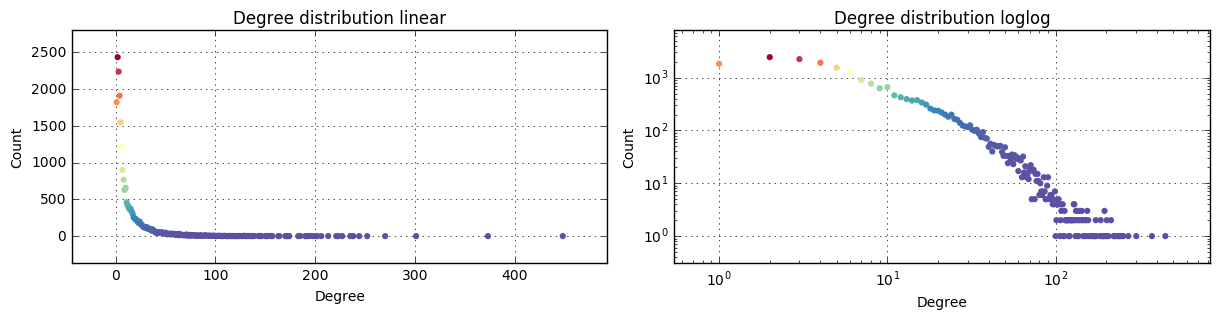

In [21]:
net.plot_degree_dist(Bdir, Bdir.in_degree().values(), plt.cm.Spectral_r)

Points on the loglog scale follow something very similar to line which is an indicator that the in-degrees of the network (number of actors acted in a movie) have the scale-free distribution. We would like to try to figure out why this type of distribution is present in the network. We've found some evidence on degree powerlaw distribution of co-stardom network. The co-stardom network with size of 212,250, average degree of 28.78, and clustering coefficient of .78 has the scale-free degree distribution $p(k)=k^{γ_{actor}}$, with an exponent $γ_{actor}=2.3±0.1$ (Barabási and Albert, 1999), (Albert and Barabási, 2000). Our network is bipartite, and its average clustering coefficient is 0 as nodes within the same projection do not connect to each other, thus there are no triangles in the graph. More on clustering coefficient we will talk in the section where we analyze bipartite network projections $M$ and $A$. Having the scale-free degree distribution, we must think of preferential attachment and network growth. Our guess is that movies with the most prominent figures will drive another actors to play in them. Also the growth is present, as the actor network continues to expand through the release of new movies.

We also see that the most number of actors played in a movie is 2, following by 1 actor, 3, 4, etc. Very interesting is the ovservation that so many movies had so few actors. Let us check what kind of movies are they. 

In [22]:
tab = Table()
tdata = []
while len(tdata)<10:
    node = random.choice([m for m, d in Bdir.in_degree().iteritems() if d==1])
    if title(node) and release_year(node):
        tdata.append((
            node, 
            title(node),
            release_year(node),
            Bdir.in_degree(node)
        ))
tab.from_tuples(tdata, columns=['ID', 'Title', 'Release year', 'Degree'])
tab.sort_values(by='Release year', ascending=False)
tab.display()


        ID                              Title  Release year  Degree
1  3817710                       The Swelling          2016       1
3  3649716  Songs from the Sarlacc: Star W...          2016       1
7  3827794                    The Walk Home 2          2016       1
2  3261658  Koshmar na Olimpiade. Gibel So...          2014       1
5  3761842                         The Hybrid          2014       1
6  3593521              Sao hoa noi day gieng          2014       1
0  3553913                           Recalled          2012       1
8  3958682  Yuichi: The Beginning of the E...          2011       1
4  2801710               Attack of the Aliens          2010       1
9  2908867                           Cinésens          2006       1



Despite the many actors played in that movie, IMDB states only one star on its website. So it seems that for the most movies, imdb.com doesn't list all the normally uncredited extras in the cast, maybe except the few (wee see a movie with 448 links).



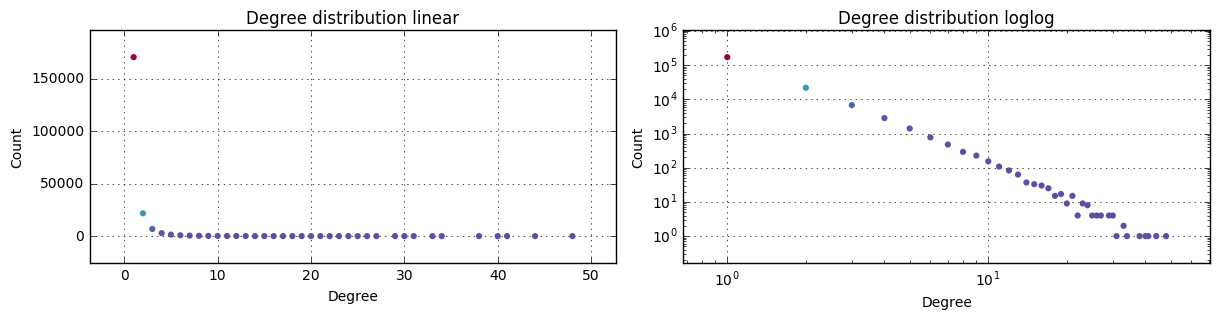

In [23]:
net.plot_degree_dist(Bdir, Bdir.out_degree().values(), plt.cm.Spectral_r)

The out-degrees, similar to in-degrees, also follow the powerlaw distribution. Those are outgoing degrees of actor nodes. The more movies an actor has played in, the more familiar is a casting director with his skills. Hence, the higher the degree of an actor in the actor network, the higher are the chances that he will be considered for a new role.

### Friendship paradox

Next interesting aspect of scale-free networks is the friendship paradox that states that that most people have fewer friends than their friends have, on average. The following method prints how many nodes have $\bar{k}$ lower, same and higher than $\bar{k}$ of their neighbors. Will will test the friendship paradox on 1000 random nodes, including both movie and star nodes.

In [24]:
net.friendship_paradox(Bip, 1000)


   Nodes  Lower  Same  Higher  Time (sec)
0   1000    936     3      61    0.073965



The test verifies the friendship paradox: The most of the randomly selected nodes have an average number of links lower than their neighbors have.

In [25]:
edges = None
nbottom = None
ntop = None
Bdir = None

In [26]:
nx.write_gpickle(Bip, './data/Bip')

## Bipartite network projections

Bipartite network projection is an extensively used method for compressing information about bipartite networks ([read here](https://en.wikipedia.org/wiki/Bipartite_network_projection)). For the convenience of directly showing the relation structure among a particular set of nodes, bipartite networks are usually compressed by one-mode projection. This means that the ensuing network contains nodes of only either of the two sets, and two $M$ (or, alternatively, $A$) nodes are connected only if when they have at least one common neighboring $A$ (or, alternatively, $M$) node. We will generate two projections: they will consist of nodes with attribute `bipartite=0` and `bipartite=1` respectively. All heavy analysis tools will be applied on those projections. 

In [27]:
A_nodes, M_nodes = net.bipartite_sets(Bip)


   Top nodes  Bottom nodes  Time (sec)
0      13989        172650    0.761551



## Top network projection (movies)

The top network projection $M$ is an one-mode projection which contains nodes with attribute `bipartite=1`. Nodes in this projection correspond to movies which collaborate only if connected through an actor. We will perform a set of analytic techniques to uncover the real structure of the collaboration network, like analysis of centralities, assortative mixing, and communities. We will take into account different attributes which can be referred to movies and test whether they have an impact on the network structure.

In [28]:
M = net.bipartite_projection(Bip, M_nodes)


       N       L  Components  Larg. component         C       p  k_min  k_max  \
0  13989  127209           1            13989  0.358204  0.0013      1    343   

   k_median     k_mean  Time (sec)  
0       6.0  18.187004    1.585475  



The amount of links might be suprising by this relatively small amount of nodes, but we must take into consideration that if 10 movies are connected through the same actor than they build a complete graph with $10*\frac{9}{2}=45$ links in $M$. The maximal amount of links possible for this number of nodes is $L_{max}=13989*\frac{13988}{2}=97839066$, which is "the worst-case scenario". If we divide $L_{max}$ by $L$ we get the probability $p=0.0013$ (which is 120x bigger than that of $Bip$) of two random nodes to be connected.

Before we start looking at the visual representation of $M$, take a look at the depth of $M$. For this we select the least connected node in $M$ and start BFS.

In [29]:
depth_M = net.depth(M, root=sorted(nx.degree(M).items(), 
                                   key=lambda x: x[1])[0][0])


    Level  Nodes   Visited  Time (sec)
0       0      1  0.000071    0.000021
1       1      1  0.000143    0.000015
2       2      3  0.000357    0.000019
3       3      1  0.000429    0.000010
4       4      2  0.000572    0.000008
5       5     74  0.005862    0.000216
6       6   2400  0.177425    0.009296
7       7   6873  0.668740    0.378944
8       8   3492  0.918364    0.092367
9       9    892  0.982129    0.018929
10     10    176  0.994710    0.004005
11     11     46  0.997998    0.000718
12     12     18  0.999285    0.000376
13     13      7  0.999786    0.000125
14     14      3  1.000000    0.000255



Cardinality on each level grows rapidly: the network is much more connected than $Bip$. The diameter of $M$ from the root node is 14. We will continue the tradition of showing the nodes behind those levels. 

In [30]:
tab = Table()
tdata = []
for lvl, nodes in depth_M.iteritems():
    if lvl>2:
        break
    top_nodes = sorted(M.degree(nbunch=nodes).items(), key=lambda x: x[1], reverse=True)
    for i, (node, deg) in enumerate(top_nodes[0:5]):
        tdata.append(('' if i!=0 else lvl, node, title(node), release_year(node), deg))
tab.from_tuples(tdata, columns=['Level', 'ID', 'Title', 'Year', 'Degree'])
tab.display()


  Level       ID                              Title  Year  Degree
0     0  3461042       Offloading for Mrs. Schwartz  2011       1
1     1  3834186  The Zucchini That Ate New York...  2009       4
2     2  2872994  Burgerface vs. Count Blackula ...  2016       4
3        2872993  Burgerface vs. Count Blackula ...  2015       3
4        3769486                       The Last Man  2009       3



The table above just extends the information we have got earlier. If you have got yourself in troubles understanding what are all the levels we are talking about now: **compressed network $M$ is just $Bip$ with absorbed actor nodes, thus each level $i$ in $M$ contains the same nodes as level $2*i$ in $Bip$**. For example, nodes on level 1 in table above are the same as nodes on level 2 in table for $Bip$. The only difference is the order of records, because degrees in $Bip$ and $M$ are different. In table displayed above, film *Godzilla (2014)* takes 2nd place (instead of 4th) as the amount of connected movies in $M$ is higher than the size of its cast in $Bip$.

If we choose `depth=2` for drawing, the number of nodes will be overwhelming. Thus let us experiment with `depth=1`. As for the bipartite graph, we will take a look at the 1-level neighbors of the root movie.


    N    L  Components  Larg. component         C         p  k_min  k_max  \
0  38  153           1               38  0.775173  0.217639      1     37   

   k_median    k_mean  Time (sec)  
0       5.0  8.052632    0.049941  

Attribute values: 1


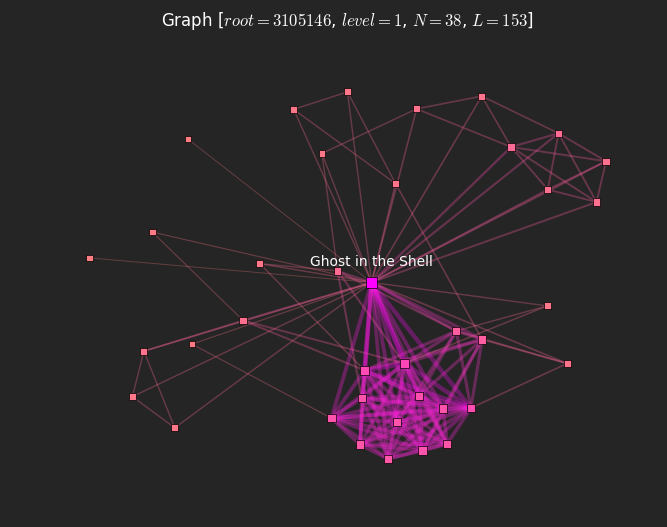

In [74]:
net.draw_graph_attr(
    M, 
    'bipartite', 
    {1: plt.cm.spring_r},
    depth=1, 
    root=root_movie,
    nlabels={1: 1},
    mongo=mongo,
    labelsmap='titles_map'
)

All of the **sci-fi movies** displayed on this plot are connected through actors which played in the root movie. We see there are not so many: Scarlett Johansson, for example, has played in 14 sci-fi movies. If you count the amount of movies in the $Bip$ version, than you would get $N$. Average clustering coefficient $C=0.77$ means that the cast of the root movie has played not in the same movies. Average degree $k_{mean}=8.05$ means that each actor played in 8 movies on average.

### Degree distribution

Now, having a totally new network, we will look at the degree distribution. At this time, we will count all links together rather than incoming and outgoing links separately, as the network is undirected. We will plot the distribution in the same manner as we did it before. By passing root argument we can highlight the location of the root on the scale.

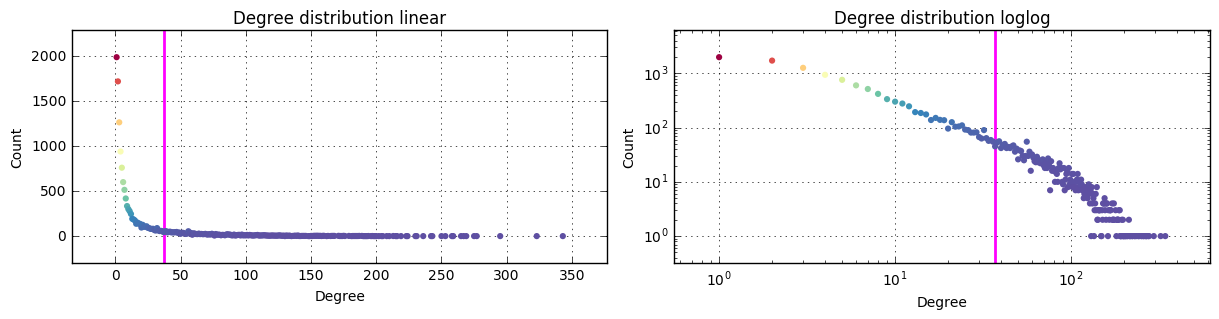

In [32]:
net.plot_degree_dist(M, nx.degree(M).values(), plt.cm.Spectral_r, root=root_movie)

Despite the compressed bipartite version (which has some different properties compared to $Bip$), the power law distribution hasn't suffered a lot. Still, the most nodes possess only 1 link (an actor acted in two movies overall), than 2 links (...in two movies), etc. But why are the degrees in $M$ not much higher (or maybe even lower) than in $M$? Let's find out. We will pick up 10 most connected movies in the $Bip$, count their 2-level neighbors (movies connected through actors) and compare to the degree in $M$. We also want to know whether $M$ was built properly.

In [33]:
tab = Table()
tdata = []
for node, d in sorted(nx.degree(Bip).items(), key=lambda x: x[1], reverse=True)[:10]:
    len_nbnb_Bip = len(set([nbnb for nb in Bip.neighbors(node) for nbnb in Bip.neighbors(nb)]))-1
    len_nb_M = nx.degree(M)[node]
    tdata.append((node, title(node), release_year(node), d, len_nbnb_Bip, len_nb_M, len_nbnb_Bip==len_nb_M))
tab.from_tuples(tdata, columns=['ID', 'Title', 'Year', 'Degree (Bip)', '2-level neighbors (Bip)', 'Degree (M)', 'Match'])
tab.display()


        ID                              Title  Year  Degree (Bip)  \
0  2782722  Angry Video Game Nerd: The Mov...  2014           448   
1  2821381  Batman v Superman: Dawn of Jus...  2016           373   
2  2958572               Deadlands 2: Trapped  2008           301   
3  2909822  Citizen Toxie: The Toxic Aveng...  2000           270   
4  3209917                     Iron Man Three  2013           252   
5  3235150                     Jurassic World  2015           244   
6  2884253  Captain America: The Winter So...  2014           238   
7  3661609                         Stake Land  2010           237   
8  2766357                          Allegiant  2016           235   
9  2763274                           Alienate  2016           227   

   2-level neighbors (Bip)  Degree (M) Match  
0                      111         111  True  
1                      243         243  True  
2                       20          20  True  
3                      155         155  True  
4   

This table is a proof that one-mod projection $M$ was calculated properly. Moreover, we now know that there are many actors who played only in one particular movie $m$ (at least within the same genre), resulting in a $k_{m,proj}=0$. If they weren't, then either 1) the amount of 2-level neighbors must have been bigger than the degree, or 2) stars must have played in other movies more likely together. We will illustrate this hypothesis by drawing the graph with the most linked movie as the root.


     N    L  Components  Larg. component    C         p  k_min  k_max  \
0  560  564           1              560  0.0  0.003603      1    448   

   k_median    k_mean  Time (sec)  
0       1.0  2.014286    0.437482  

Attribute values: 0, 1


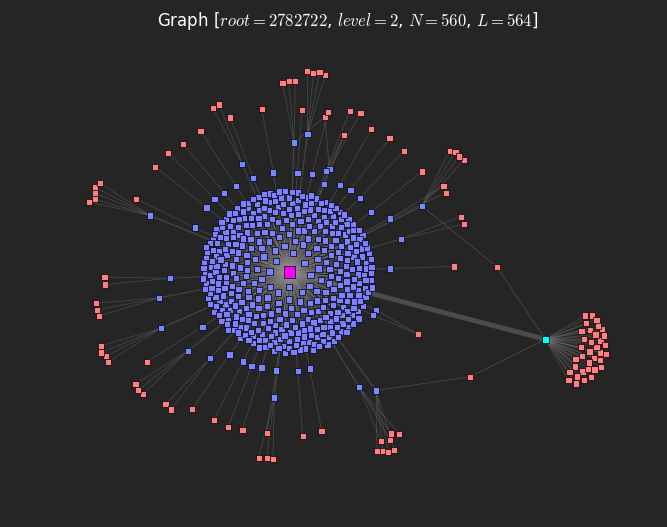

In [34]:
net.draw_graph_attr(
    Bip, 
    'bipartite', 
    {0: plt.cm.cool_r, 1: plt.cm.spring_r},
    depth=2, 
    root=max(nx.degree(Bip).items(), key=lambda x: x[1])[0]
)

As suggested, for the most actors, this sci-fi movie (which is *"Angry Video Game Nerd: The Movie"*) is the only one within science fiction genre which they played in. The most of the remaining stars haven't acted in any picture together. Hence, the main reason why the degree of a high-linked picture in $M$ is mostly lower than the degree of the same picture in $Bip$ is that that picture is the only one many actors acted in. 

### Centrality

First we are going to explore the 5 most central nodes in $M$ according to a few different centrality definitions. We will look at the betweenness centrality, closeness centrality, degree centrality and eigenvector centrality. Method `NetXHelper.calc_centr` calculates those centralities with respect to the provided parameters: by passing already known parameters `depth` and `root` we are able to limit the observation area. The main bottleneck we observed is calculation of the degree and closeness centralities, both produce the poorest performance, thus limiting the area of observation is a smart move towards taking a quick look at the results.

In [35]:
centr_M = net.calc_centr(M)


    Centrality   Time (sec)
0  Betweenness  4183.791415
1    Closeness   754.722728
2  Eigenvector     0.915440
3       Degree     0.027489



We decided to perform centrality analysis on the entire $M$, as the cardinality of $M$ is not too huge to wait for results for weeks. Processing time takes its peak at betweenness calculation. Here, a small trick can be used in order to speed up the things a bit: python package called `graph-tool`, which is implemented in C++ with templates (using the Boost Graph Library), and hence is much faster (up to two orders of magnitude) and uses much less memory. Now we are going to display the movies with the greatest centrality in terms of each centrality definition. 

In [36]:
for t, cent in centr_M.iteritems():
    print t
    tab = Table()
    tuples = []
    for n, c in sorted(cent.items(), key=lambda x: x[1], reverse=True)[:5]:
        tuples.append((n, title(n), release_year(n), M.degree(n), c))
    tab.from_tuples(tuples, columns=['ID', 'Title', 'Year', 'Degree', 'Centrality'])
    tab.display()

Betweenness

        ID                              Title  Year  Degree  Centrality
0  3209917                     Iron Man Three  2013     269    0.022194
1  3859989     Transformers: Dark of the Moon  2011     323    0.019345
2  2821381  Batman v Superman: Dawn of Jus...  2016     243    0.018016
3  2884253  Captain America: The Winter So...  2014     242    0.016868
4  3662953                          Star Trek  2009     265    0.014285

Closeness

        ID                              Title  Year  Degree  Centrality
0  3209917                     Iron Man Three  2013     269    0.345408
1  3859989     Transformers: Dark of the Moon  2011     323    0.341880
2  2884253  Captain America: The Winter So...  2014     242    0.340001
3  2805650            Avengers: Age of Ultron  2015     210    0.338226
4  3662953                          Star Trek  2009     265    0.337989

Degree

        ID                              Title  Year  Degree  Centrality
0  3246427           Kaze no t

#### Betweenness centrality
Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. Hence, nodes that have a high probability to occur on a randomly chosen shortest path between two randomly chosen nodes have a high betweenness. Betweenness centrality is related to a network's connectivity, in so much as high betweenness nodes have the potential to disconnect graphs if removed. Betweenness does not reflect the degree of a node. In $M$, a high betweenness centrality would indicate that the movies would take you to a relatively large number of other movies in relatively few steps and likewise. If we take a look at the results, we recognize some well-known movies having the highest betweenness. *Iron Man Three, 2013* appears on 2% of all shortest paths between two random movies. Like other movies in top 5, it presents in the network as hub between different areas, and if removed, the network may become disconnected (but we doubt it). 

#### Closeness centrality
Closeness centrality measures the mean distance from a node to other nodes. The more central nodes are in the graph, the higher closeness they have. The most of the movies that have the highest closeness centrality also have the highest betweenness centrality. Visually, they appear in the centre of the graph. The actors of those movies are best connected with all kinds of other movies, thus have to be very popular.

#### Degree centrality
Degree centrality is the most basic method of defining centrality, basing the centrality only on the number of neighbours a node has. It doesn't make (almost) any sense to rely on degree centarlity only, as IMDB sometimes list all the normally uncredited extras in the cast. As expected, many of the movies with the highest degree centrality in the table above are not that popular. 

#### Eigenvector
Eigenvector centrality on the other hand tells you the probability that a random walker would be present on a randomly chosen node. The eigenvector centrality thesis reads: A node is important if it is linked to by other important nodes. The most movies in the table are animations with many-many actors, and they are apparently linked to each other, thus their eigenvector centrality is very high. 

In order to understand the centralities better, we illustrate the distribution of various centralities in a small network.


      N      L  Components  Larg. component         C         p  k_min  k_max  \
0  1707  27125           1             1707  0.380558  0.018629      1    242   

   k_median     k_mean  Time (sec)  
0      20.0  31.780902    0.415086  


    Centrality  Time (sec)
0  Betweenness   68.687700
1    Closeness   12.959381
2  Eigenvector    0.336555
3       Degree    0.003010



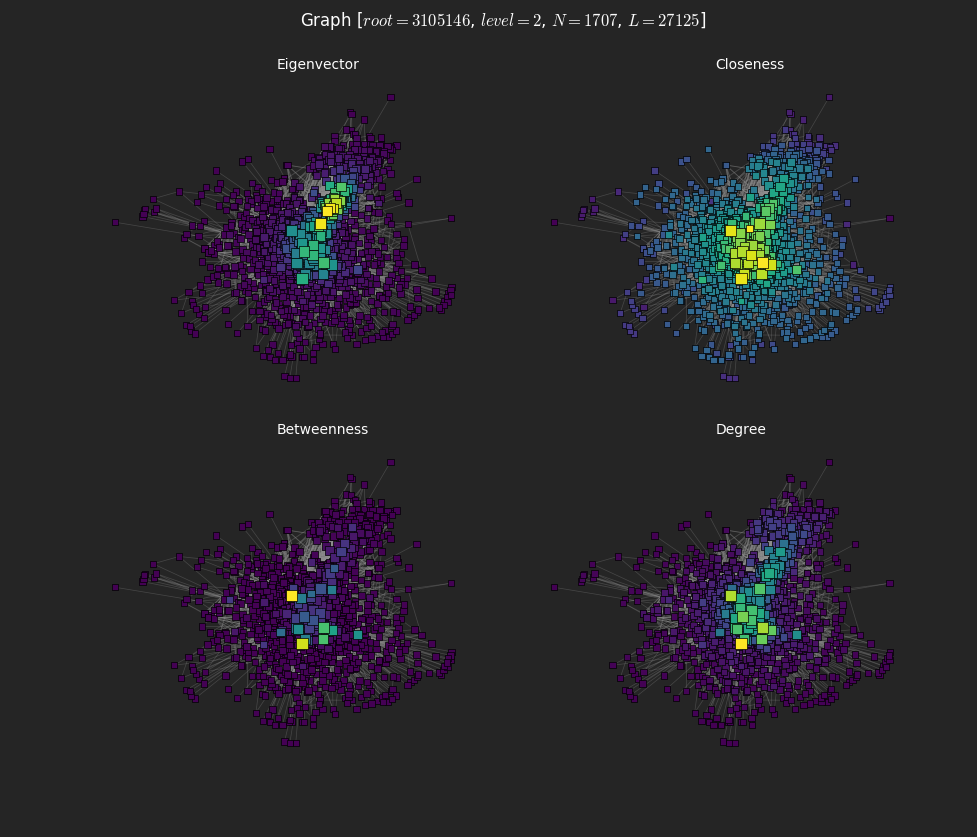

In [37]:
net.draw_graph_centr(
    M, 
    plt.cm.viridis,
    depth=2, 
    root=root_movie
)

In this example we took a root movie *Ghost in the Shell (2017)* and calculated centrality for nodes up to 2nd level of traversal. Centrality of a node is reflected by its color, the degree by its size. We observe different patterns for each of the graphs. The nodes with the highest eigenvector centrality are located along the two communities (maybe they are not communities, but can be distinguished as those on the graph). The more central are the nodes, the higher is their closeness, as sum of the length of the shortest paths decreases. The nodes with the highest betweenness lie also in the center of graph connecting many nodes together. The degree centrality reflects the number of neighbors a node has, the most linked nodes are located in the center of the graph where the traversal started (which is not suprising). Let us analyze the centrality of *Ghost in the Shell (2017)*.

In [38]:
tab = Table()
tdata = []
for title, cent in centr_M.iteritems():
    tdata.append((title, cent[root_movie], sorted(cent.values()).index(cent[root_movie])/len(cent.values())))
tab.from_tuples(tdata, columns=['Centrality', 'Value', 'Rank [min, max]'])
tab.display()


    Centrality     Value  Rank [min, max]
0  Betweenness  0.000876                0
1    Closeness  0.292434                0
2       Degree  0.002645                0
3  Eigenvector  0.001970                0



Table displays centrality along with the rank of the centrality on the entire scale (from minimum to maximum centrality in the entire graph). *Ghost in the Shell (2017)* seems to have relatively high ranks among all centralities. All centralities are higher than of 85% of all movies, meaning it is well connected. Another method to take an insight into centralities is plotting histograms of each one. By passing root argument we are able to identify the root on the distribution scale.

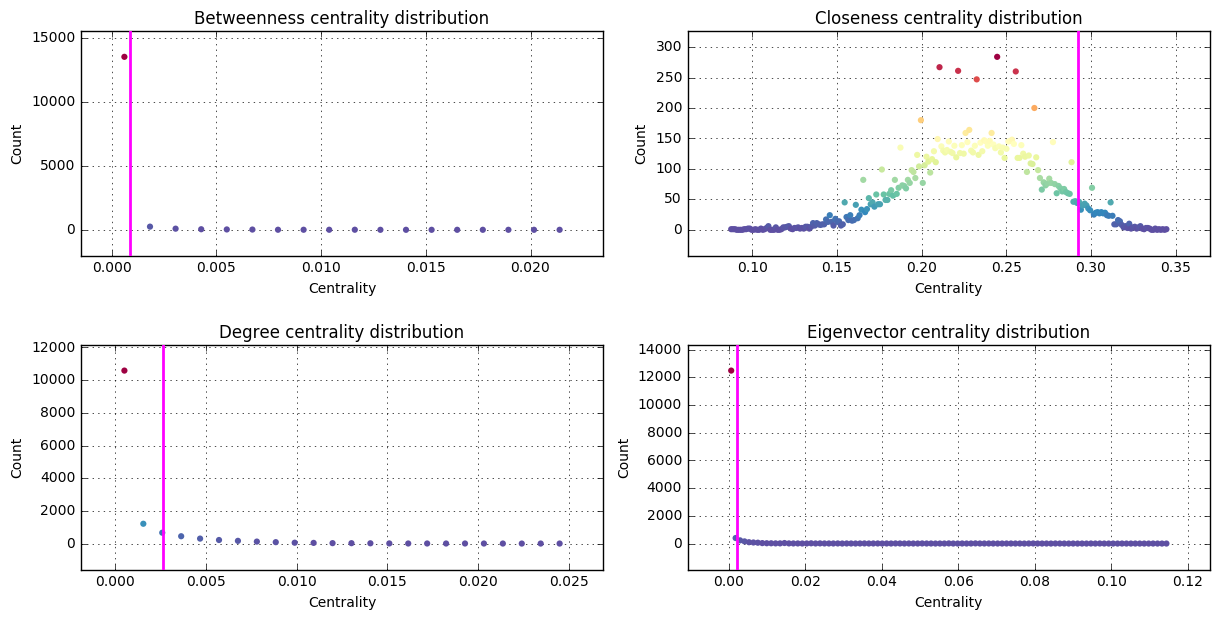

In [39]:
net.plot_centr_dist(M, centr_M, plt.cm.Spectral_r, root=root_movie)

As expected, the most of the movies are not central in the film industry (apart from the closeness measure and eigenvector measure where relatively many films have high numbers), only a few really are. *Ghost in the Shell (2017)*, while being higher ranked (in ragards to centrality) than the most movies, appears on the left side of almost every centrality distribution. The *Ghost in the Shell (2017)* film is more central than the most sci-fi movies, but still not as central as many others.

### Attach attributes

Now we move on to observe how movie attributes affect the network. This analysis step might be very interesting as it will (hopefully) help us to uncover the real structure of the network and how it has grown. We will check the assortativity of nodes in respect of all attributes, but also answer the question whether those attributes build good communities across the network. 9 different attributes will be attached to movie nodes, some of them have emerged after all links have been established (e.g., votes and gross), thus they cannot a part of the rule of network growth. But still, they might be interesting to investigate.

In [40]:
net.attach_attr_from_mongo(
    mongo, 
    M, 
    'prod_countries',
    'directors', 
    'languages', 
    'prod_companies', 
    'release_years', 
    'runtimes', 
    'votes', 
    'budgets', 
    'gross')


        Attribute  Unique   Min         Max  Time (sec)
1       directors   10409   745     4980830    3.021179
3  prod_companies    6265    21      222066    2.690675
6           votes    2539     5     1497311    0.534340
8           gross    1029    72  2787965087    0.104354
7         budgets     501     0   250000000    0.214481
5        runtimes     202     0         700    1.208779
4   release_years     111  1911        2022    0.522893
0  prod_countries      70     0         239    1.299885
2       languages      54     8         340    1.544267



The table is sorted by column "Unique", which shows number of distinct attribute values. Two types of attributes have been attached: numeric attributes which have a scale (*votes, gross, budgets, runtimes, and release_years*), and attributes which do not (*directors, prod_companies, prod_countries, and languages*). In the next step we will plot the distribution of those attributes which have scale and an absolute minimum value.

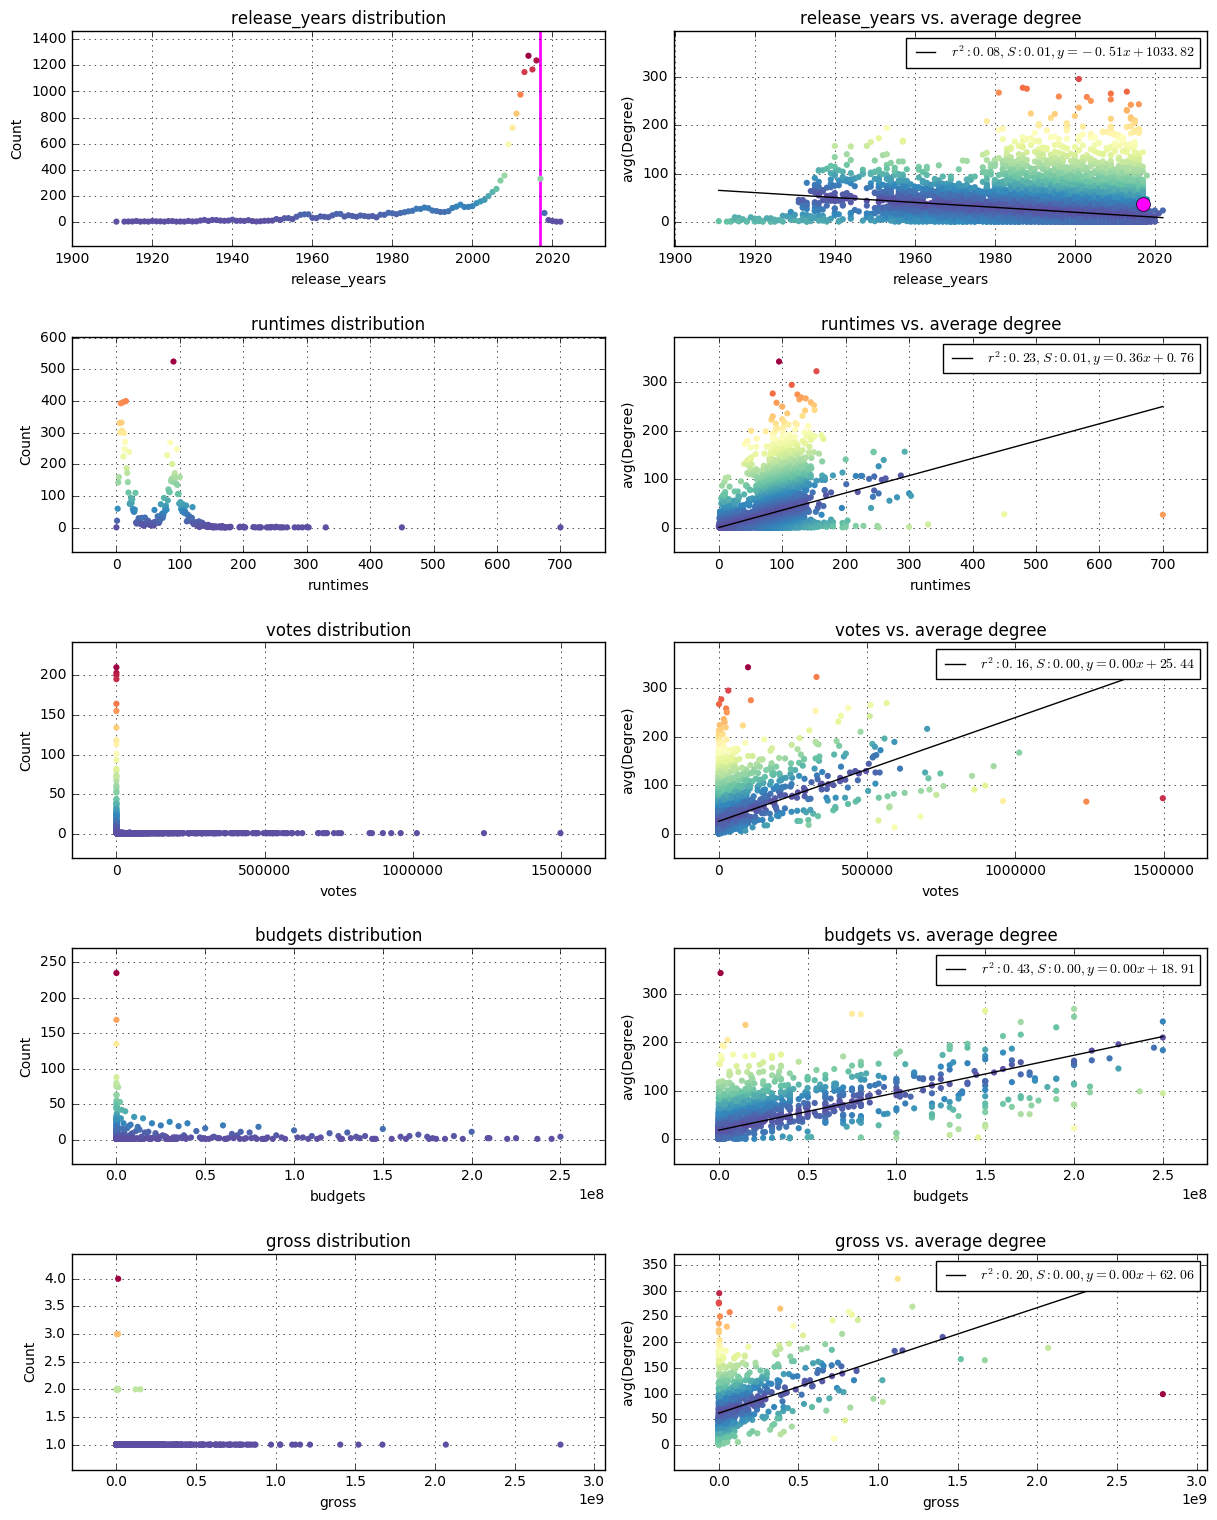

In [41]:
net.plot_attr_dist(
    M, 
    ['release_years', 'runtimes', 'votes', 'budgets', 'gross'], 
    plt.cm.Spectral_r,
    root=root_movie
)

#### Release years
Sci-fi movies have not been popular the entire time in which cinematography existed. The science fiction genre has experienced the main gain in popularity in the beginning of 2000x, when the technology for movie production evolutionized, and it goes through the peak right now. If you look at the plot of release years versus average degree, you probably will experience some kind of wow: there is really some kind of weird correlation between them. We explain it by follows: when the ara of science fiction started, there was 1) a lot of actors who played in the sci-fi movies and who got very popular for the next generations, and thus IMDB credited them on their website; 2) a bunch of actors who were very popular in this genre and played in a lot of movies. Hence, in our opinion, the amount of movies connected through the same actors was relatively high. Now, actors have wider profiles, and play in various movies of various genres rather than limit their play in one genre. This might explain why the connectivity in $M$ decreases over time. 

#### Runtimes
A lot of sci-fi movies are both short (around 10-30 min) and long (around 80-120 min). Runtimes inbetween and above are rare. Runtimes are weakly correlated with degrees ($r^2=0.24$), and this is not suprising, as the longer a movie is, the more actors play in that movie. 

#### Votes
The most numbers of votes are low. But some movies have millions of them. We discover a weak correlation ($r^2=0.17$) between votes and degrees: the more the degree of a movie is, the more votes the audience gives. 

#### Budgets
The most movies are low-budget movies. More interesting is a correlation between budgets and degrees ($r^2=0.47$): the more budget the movie has, 1) the more money it spends on cast and crew, and 2) the more profitable actors it hires, which also play in many other pictures. 

#### Gross
Gross is also positively, but weakly, correlated with degree ($r^2=0.21$). But we must be careful here, as the gross might be primarily correlated with budget a movie spends.

The *Ghost in the Shell (2017)* movie is only reflected in release years as it hasn't come out yet.

### Assortativity

Next aspect of networks which has to be discovered is assortative mixing. Assortativity is a preference for a network's nodes to attach to others that are similar in some way. By knowing assortativity we can closely approximate the behavior of the $M$. We will test assortativity towards 4 labeled attributes and 5 numeric. Numeric attributes like release year may have a very wide scale of values, which makes performance ugly. We discovered a correlation between maximal value on the scale and the performance: if some values go above ~1000, the algorithm hangs. To improve the processing time, we decided to automatically rescale all values if the maximum one is more than 1000.

In [42]:
net.assortativity(
    M, 
    {
        'prod_countries': 'attribute',
        'directors': 'attribute',
        'languages': 'attribute',
        'prod_companies': 'attribute',
        'release_years': 'numeric',
        'runtimes': 'numeric',
        'votes': 'numeric',
        'budgets': 'numeric',
        'gross': 'numeric'
    }
)


        Type       Attribute     Coef.  Time (sec)
8    numeric   release_years  0.810773    1.847071
0  attribute       languages  0.677169    2.134636
7  attribute  prod_countries  0.661638    2.304916
9     degree                  0.335176    1.605807
4    numeric         budgets  0.283897    0.409633
5    numeric        runtimes  0.223344    2.071513
6    numeric           votes  0.208597    1.407005
1    numeric           gross  0.128222    0.295434
3  attribute  prod_companies  0.062768    1.810594
2  attribute       directors  0.044619    2.323379



Assortativity in terms of $M$ is all about actors, not movies. It is given, when an actor decided to act in two different movies with similar properties. The results shown in the table illustrate that the actors are really biased towards the most of the attributes. 

#### Release years (rescaled to $[1,10]$) 
Actors tend to connect to others within the same range of release years. This seems to be well reasoned: every actor has a peak of his career, when he plays in many movies which are then connected in $M$. 

#### Languages
Actors act preferentially in movies where the same langauge is spoken. 

#### Production countries
Actors tend to act in movies produced in the same country. 

#### Degree
Results show also assortative mixing towards degree. Some actors love to act in crowded movies, some not. 

#### Budgets (rescaled to $[1,10]$)
High-paid actors act in high-budget movies. But before they got very popular, they acted in low-budget movies. Hence, movies in $M$ are connected with movies of different budgets, but many actors acted just in low-budget or high-budget movies. 

#### Runtimes
Results show low assortativity towards runtimes, that is, actors act both in short and long movies. 

All other attributes show dissortative mixing: actors do not tend to act in movies of the same production companies and directors. Gross and votes we do not take into consideration, as no assortativity is shown, and they are unknown in the time the links were established.

### Communities

Next we will see whether the attributes attached before are good communities in $M$, and maybe we will uncover some new. First of all, we will calculate the modularity (which isused in optimization methods for detecting community structure in networks) of the attributes using the `python-louvain` library. We will handle all numeric attributes as labeled by rescaling them into 10 different classes. The results are shown below.

In [45]:
net.modularity(
    M, 
    [
        'prod_countries',
        'genres',
        'directors',
        'languages',
        'prod_companies',
        'release_years',
        'runtimes',
        'votes',
        'budgets',
        'gross'
    ], 
    classes={
        'release_years': 10,
        'runtimes': 10,
        'votes': 10,
        'budgets': 10,
        'gross': 10
    }
)


        Attribute  Communities         M  Time (sec)
0  prod_countries           70  0.337346    2.150985
5   release_years           10  0.256740    2.278097
3       languages           54  0.230001    2.456623
8         budgets           10  0.096953    0.728043
6        runtimes            7  0.091087    1.783206
4  prod_companies         6265  0.062769    1.638034
2       directors        10409  0.039753    2.150462
9           gross            8  0.022208    0.270913
7           votes            9  0.021921    1.427398
1          genres            0       NaN    0.009673



As in the assortativity test above, 3 attributes produce the highest modularity in $M$: production countries, release years, and languages, that is, with $M=[0.23,0.34]$ they build communities of low to medium quality. But still, in comparison to other attributes, the network may be splitted in those attributes with 30% of probability that a new assigned to one of these communities node was classified correctly. To illustrate that only a fraction of nodes in those pseudo-communities belong to real communities, let us take a look at the example graph below. We will draw the network of all sci-fi movies made in Denmark and their connections to movies made in other countries. If amount of connections within the films produced in Denmark is higher than the amount of connections to movies made ouside of Denmark, then production countries are good communities.

In [46]:
root_danish = random.choice([n for n, a in nx.get_node_attributes(M, 'prod_countries').items() if a==154]) # Denmark
print root_danish, mongo.collect('titles_map', filter={'id': root_danish})[root_danish][0]

2791684 Arene


Attribute values: 154, -1


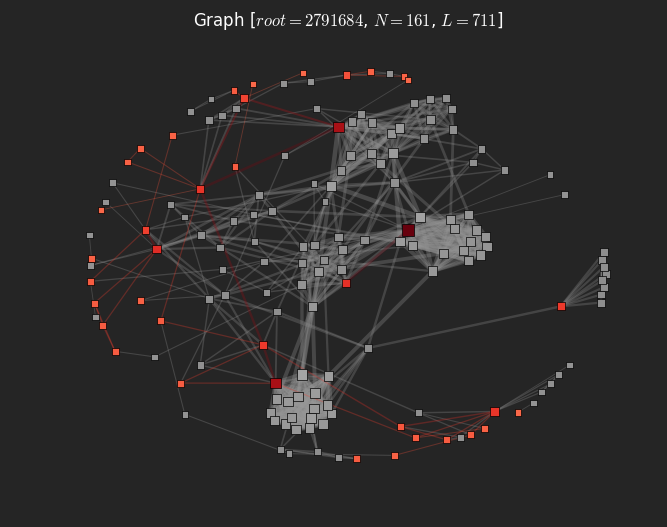

In [47]:
net.draw_graph_attr(
    M, 
    'prod_countries', 
    {154: plt.cm.Reds},
    root=root_danish
)

In the graph above we see, that less than a half of all sci-fi movies made in Denmark are interconnected. Hence, production countries, while being a somehow good estimate of the relatedness, fail to represent communities in $M$ in a best fassion. To detect real communities, we will run `community.best_partition` method of the `python-louvain` library that maximizes the modularity and leads to the appearance of communities in a given network.

In [48]:
communities_M = net.find_communities(M)


   Unique         M  Time (sec)
0      83  0.597294   11.049668



The algorithm detected 83 communities with modularity $M=0.59$, which is much higher than modularity of production countries. Let us get a feel of newly calculated modularity by drawing a random graph. But first, we have to attach communities as attributes to nodes.

In [49]:
net.attach_communities(M, communities_M)

In [50]:
community_danish = nx.get_node_attributes(M, 'communities')[root_danish]
print root_danish, community_danish

2791684 9



     N    L  Components  Larg. component         C         p  k_min  k_max  \
0  111  284           1              111  0.519673  0.046519      1     28   

   k_median    k_mean  Time (sec)  
0       4.0  5.117117    0.011555  

Attribute values: 9, -1


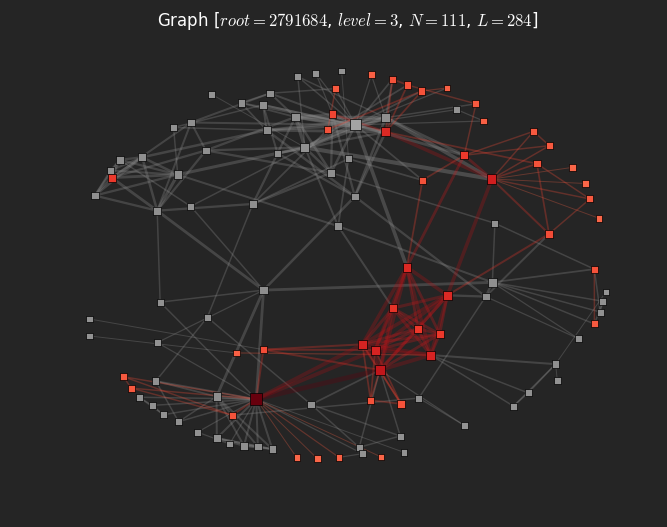

In [78]:
net.draw_graph_attr(
    M, 
    'communities', 
    {community_danish: plt.cm.Reds},
    depth=3,
    root=root_danish
)

The communities detected by lovain-algorithm are not perfect but much more better than those of attributes. We recognize it by the cardinality of links within nodes of the same community (coloured) being higher than the cardinality of links to other communities, as communities are defined as groups of densely interconnected nodes that are only sparsely connected with the rest of the network.

In [52]:
nx.write_gpickle(M, './data/M')

## Person network

After analysis of the $M$ is done, we move on with analysis of the bottom network projection $A$, which is an one-mode projection which contains nodes with attribute `bipartite=0`. Nodes in this projection correspond to actors which collaborate only if connected through a movie. The number of links of each node in $A$ means the number of "friends" an actor/actress have. Basically, we will do all the same analysis steps as above. But first, let us do some transformations on node labels. As you maybe remember, in $Bip$ we stored each `person_id` with a minus sign to make movies and actors identifiable. If we extract bottom network projection from $Bip$, all person ids will remain negatively signed. This is a no-go if we want to attach attributes to those nodes, as ids in every MongoDB collection (containing data of a certain attribute) are all positive. That is why we change the sign of all node labels to the original one. 

In [53]:
A = net.bipartite_projection(Bip, A_nodes)
nx.relabel_nodes(A, {n: -n for n in A.nodes()}, copy=False)


        N        L  Components  Larg. component         C         p  k_min  \
0  172650  5111268           1           172650  0.908539  0.000343      1   

   k_max  k_median     k_mean  Time (sec)  
0   3052      36.0  59.209592   43.991664  



As for the $M$, number of links in the network is very much higher than the cardinality. Average degree $k_{avg}=\frac{2*L}{N}=59.2$ means that each actor knows 59 actors on average. The maximal amount of links possible for this number of nodes is $L_{max}=N*\frac{N-1}{2}=14,903,924,925$, a very big number, thus $L$ of $A$ is relatively very low. If we divide $L_{max}$ by $L$ we get the probability $p=0.003$ (which is 4 times lower than in $M$) of two random nodes to be connected. Hence, $A$ is "less connected" than $M$, which is somehow counterintuitive if we take into consideration that both projections are compressed versions of the same bipartite network $Bip$, but as the amount of actors in the network is higher, the $p$ is automatically lower.

Before we start looking at the visual representation of $A$, take a look at the depth of $A$.

In [54]:
depth_A = net.depth(A, root=root_actor)


    Level  Nodes   Visited  Time (sec)
0       0      1  0.000006    0.000046
1       1   1148  0.006655    0.110518
2       2  30111  0.181060    2.371592
3       3  88200  0.691920    4.562771
4       4  41739  0.933675    2.538976
5       5   9208  0.987008    0.693684
6       6   1606  0.996310    0.117485
7       7    372  0.998465    0.021602
8       8    115  0.999131    0.004979
9       9     90  0.999652    0.001704
10     10     27  0.999809    0.001183
11     11     33  1.000000    0.003484



Take notice: the depth of $A$ is the same as of $M$, because both projections are compressed versions of the same bipartite network $Bip$, and the root actress in $A$ played in the root movie of $M$.

In [55]:
tab = Table()
tdata = []
for lvl, nodes in depth_A.iteritems():
    if lvl>2:
        break
    bottom_nodes = sorted(A.degree(nbunch=nodes).items(), key=lambda x: x[1], reverse=True)
    for i, (node, deg) in enumerate(bottom_nodes[0:5]):
        tdata.append(('' if i!=0 else lvl, node, name(node), birth_year(node), deg))
tab.from_tuples(tdata, columns=['Level', 'ID', 'Name', 'Year', 'Degree'])
tab.display()


   Level       ID                 Name  Year  Degree
0      0  3059865  Johansson, Scarlett  1984    1148
1      1  1265583            Lee, Stan  1922    3052
2         1814095        Ramos, Diezel          2270
3         1039709   Jackson, Samuel L.  1948    1680
4          666910          Falvo, Mark          1675
5         1932888     Sacco, Anthony J          1664
6      2  1123549       Kaufman, Lloyd  1945    2867
7         2368773        Welker, Frank  1946    2175
8          273885        Bronson, Greg          1426
9         2434301     Yamadera, Kôichi  1961    1158
10        1665524         Otto, Johnny          1155



*Scarlett Johansson (1984)* has 1148 connections, that is, according to IMDB she has acted with 1184 other actors. The number of links may appear overwhelming, but it is well reasoned if you count size of cast of all those films she has played in.

In [56]:
len(set([n 
         for nb in Bip.neighbors(-root_actor) 
         for n in Bip.neighbors(nb)])-set([-root_actor]))

1148

Among those levels in the table *Stan Lee (1922)* appears to have the most number of "friends". As for the bipartite graph, we will try to visualize a part of network by drawing a graph. As root actor we will select someone less connected than *Scarlett Johansson*, as we want mainly to demonstrate some basic structure and connectivity of $A$.

In [57]:
actors_by_degree = dict(map(reversed, nx.degree(A).items()))


     N      L  Components  Larg. component         C         p  k_min  k_max  \
0  408  12149           1              408  0.990656  0.146324      7    167   

   k_median     k_mean  Time (sec)  
0      65.0  59.553922    1.705511  

Attribute values: 0


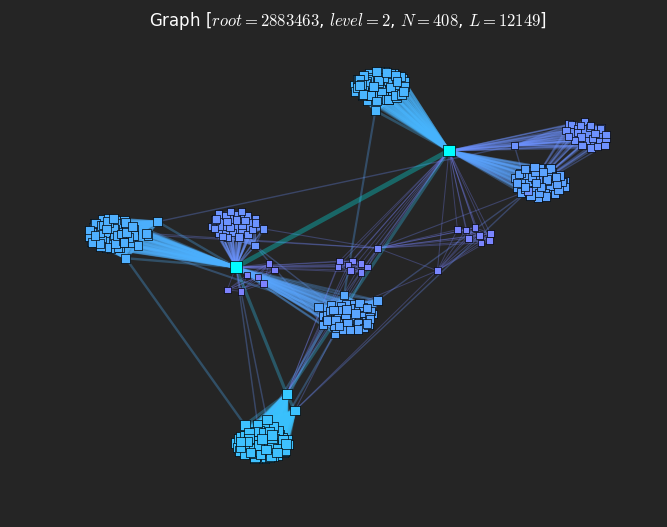

In [58]:
net.draw_graph_attr(
    A, 
    'bipartite', 
    {0: plt.cm.cool_r},
    depth=2,
    root=actors_by_degree[10]
)

Each node on the plot is an actor/actress. Notice how different is that plot compared to plots of $M$: that is due to the fact that the mean degree in $A$ is much higher than in $M$. While $k_{max,M}=343$ (the maximum number of movie-to-movie connections), the maximum number of "friends" in $A$ is $k_{max,A}=3052$, which is almost 9 times higher. But also degree distribution in $M$ is much more flatter than in $A$, meaning that the nodes in $A$ are much more connected compared to related nodes in $M$. As the co-stardom network growth is defined by addition of movies rather than stars, with time, stars get more and more connections to movies and many become hubs, while movies establish only limited number of links to a limited set of actors already present in the network. Thus what we are currently looking at are the hubs of $Bip$.

### Degree distribution

Now, as done for $M$, we will look at the degree distribution. We will plot the distribution in the same manner as we did it before. By passing root argument we can highlight the location of the root on the scale.

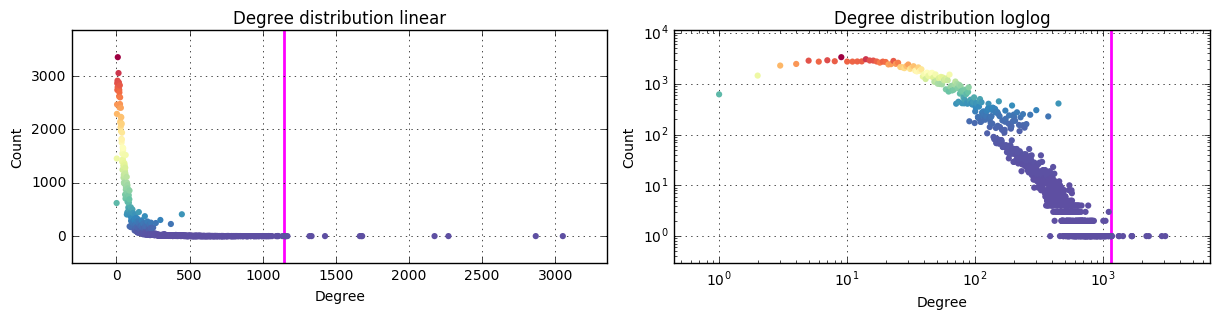

In [59]:
net.plot_degree_dist(A, nx.degree(A).values(), plt.cm.Spectral_r, root=root_actor)

The beautiful plot with loglog scale on the right shows the power law distribution of degrees in $A$. Compared to all degree distribution plots above, this one shows the most common degree around 10. We also see that much more nodes have high degrees. 

### Centrality

Centrality analysis will be performed on a limited area of the network ($depth=1$), as the betweenness and closeness centrality calculations are the main bottlenecks and for the graph with $depth=2$ require more than 24 hours (and we are a bit in hurry). Because $A$ is MUCH MORE connected than $M$, already at the level of 1 we expect a significant number of nodes and links to appear. As root we will use the root actor selected before. 

In [60]:
centr_A = net.calc_centr(A, depth=1, root=root_actor)


      N      L  Components  Larg. component         C         p  k_min  k_max  \
0  1149  89607           1             1149  0.946067  0.135866     24   1148   

   k_median     k_mean  Time (sec)  
0     135.0  155.97389    2.026245  


    Centrality  Time (sec)
0  Betweenness   92.336438
1    Closeness   18.575630
2  Eigenvector    5.137442
3       Degree    0.001203



We also expect the most central nodes to be biased towards the root actor (or actress, *Scarlett Johansson (1984)*). A different picture can obtained by increasing the depth of traversal, but in terms of the limited time we have we will work with that data and only illustrate that the analysis procedure was defined right. Still, the area we have chosen is not small: 1149 nodes and 89,607 links is an average network (imagine working with 100 times more than that). Let us analyze the central figures of this subgraph.

In [61]:
for t, cent in centr_A.iteritems():
    print t
    tab = Table()
    tuples = []
    for n, c in sorted(cent.items(), key=lambda x: x[1], reverse=True)[:5]:
        tuples.append((n, name(n), birth_year(n), A.degree(n), c))
    tab.from_tuples(tuples, columns=['ID', 'Name', 'Year', 'Degree', 'Centrality'])
    tab.display()

Betweenness

        ID                 Name  Year  Degree  Centrality
0  3059865  Johansson, Scarlett  1984    1148    0.462108
1  1265583            Lee, Stan  1922    3052    0.031672
2  1039709   Jackson, Samuel L.  1948    1680    0.017619
3   656705         Evans, Chris  1981    1320    0.016537
4   195448        Bettany, Paul  1971    1001    0.016496

Closeness

        ID                 Name  Year  Degree  Centrality
0  3059865  Johansson, Scarlett  1984    1148    1.000000
1  1265583            Lee, Stan  1922    3052    0.752294
2   656705         Evans, Chris  1981    1320    0.700000
3  1039709   Jackson, Samuel L.  1948    1680    0.676488
4   195448        Bettany, Paul  1971    1001    0.665893

Degree

        ID                 Name  Year  Degree  Centrality
0  3059865  Johansson, Scarlett  1984    1148    1.000000
1  1265583            Lee, Stan  1922    3052    0.670732
2   656705         Evans, Chris  1981    1320    0.571429
3  1039709   Jackson, Samuel L.  1948 

$depth=1$ of the network contains the root actor, links between him and other actors, but also links between those actors, all forming a closed area. *Scarlett Johansson (1984)* is the middle of the graph, as the graph traversal started from her. The second most central figure in that subgraph is *Stan Lee (1922)*, having the most links (3052, that is, his co-actors).


      N      L  Components  Larg. component         C         p  k_min  k_max  \
0  1149  89607           1             1149  0.946067  0.135866     24   1148   

   k_median     k_mean  Time (sec)  
0     135.0  155.97389    2.552559  


    Centrality  Time (sec)
0  Betweenness   91.369995
1    Closeness   19.146618
2  Eigenvector    3.314531
3       Degree    0.002497



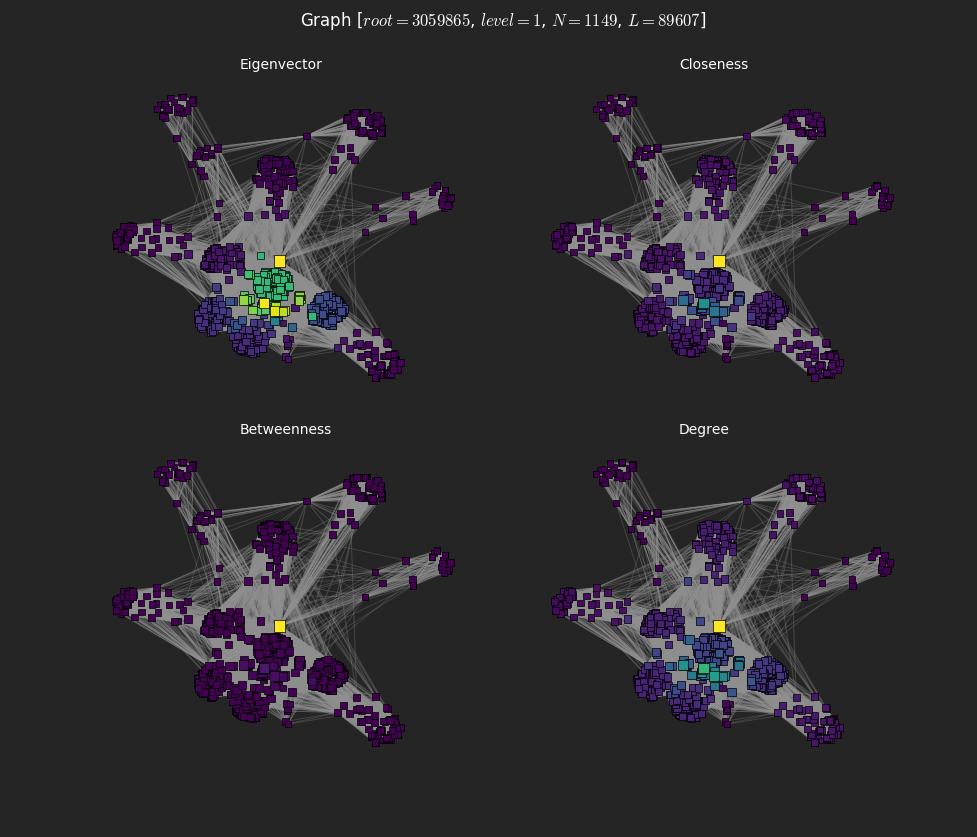

In [62]:
net.draw_graph_centr(
    A, 
    plt.cm.viridis,
    depth=1, 
    root=root_actor
)

That node coloured with yellow is *Scarlett Johansson (1984)*. Those communities are actors/actresses who acted in the same movies. The most suprising centrality measure is eigenvector centrality, where those nodes glow which have highest degree and also connect to nodes with highest degree. In terms of $A$, those are movies with biggest cast. If you are unsure what other centralities mean, go back to the analysis of $M$, there we describe them in detail. What we will do further is discovering distributions, although they might be a bit of limited meaning because of the limitedness of the network area.

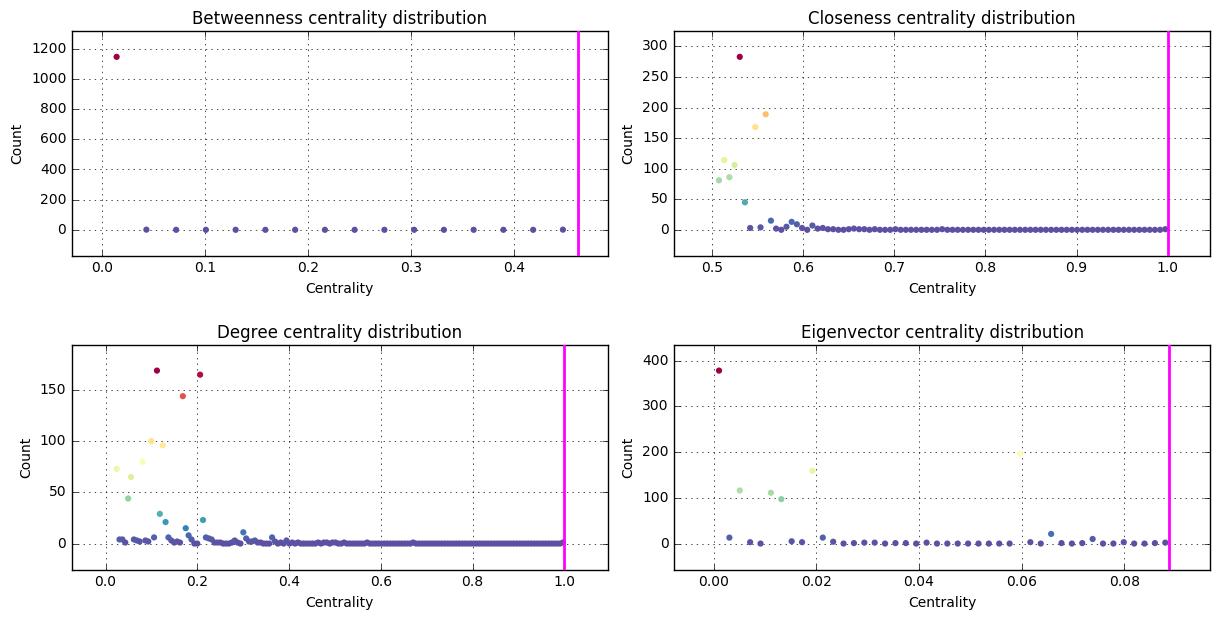

In [63]:
net.plot_centr_dist(A, centr_A, plt.cm.Spectral_r, root=root_actor)

Centrality distributions are somewhat disturbed compared to those of $M$, because, 1) we limited area to $depth=1$, 2) there are a lot more central nodes due to increased connectivity. But in general we expect the powerlaw distribution.

### Attach attributes

Now we move on to observe how actor attributes affect the network. We will check the assortativity of nodes in respect to birth place and year, and height, but also answer the question whether those attributes build good communities across the network.

In [64]:
net.attach_attr_from_mongo(
    mongo, A, 
    'birth_places',
    'birth_years',
    'heights'
    )


      Attribute  Unique   Min   Max  Time (sec)
0  birth_places     205     0   384   16.810919
1   birth_years     161  1848  2013    4.566443
2       heights     147     1   731    3.414198



The table is sorted by column "Unique", which shows number of distinct attribute values. Two types of attributes have been attached: numeric attributes which have an absolute zero on the scale (*birth_years* and *heights*), and one attribute which doesn't (*birth_places*). In the next step we will plot the distribution of those attributes which have scale and an absolute minimum value.

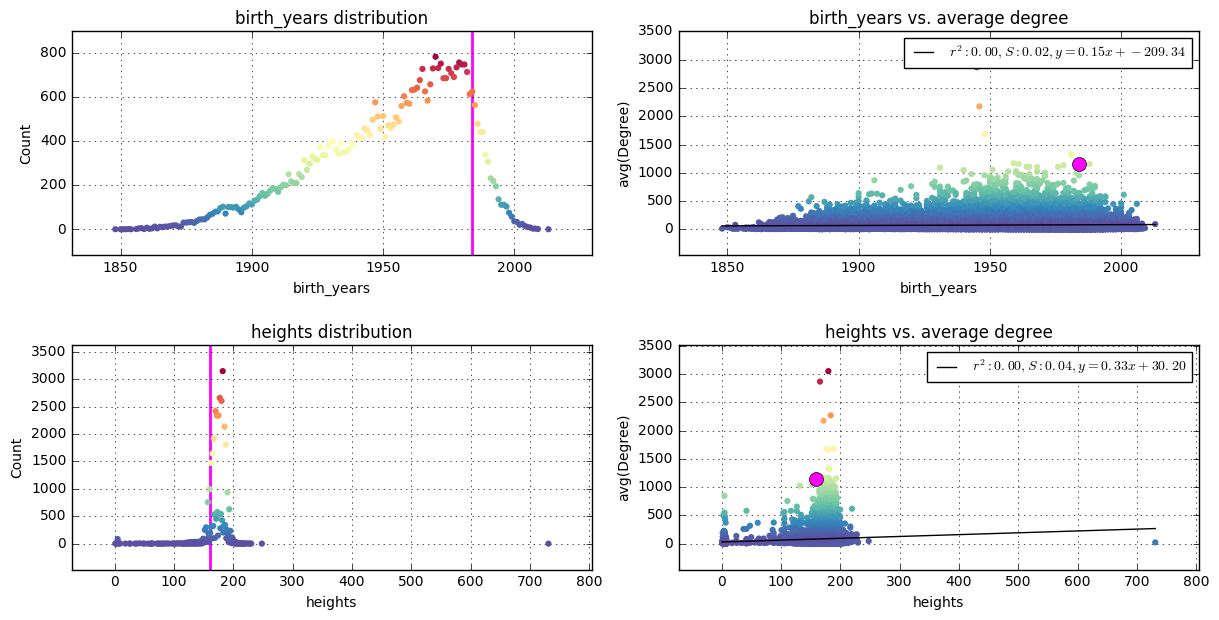

In [65]:
net.plot_attr_dist(
    A, 
    ['birth_years', 'heights'], 
    plt.cm.Spectral_r,
    root=root_actor
)

We notice following characteristics: 

#### Birth year
The most actors of sci-fi films were born from 1950 to 1980. Actors who were born in later years are younger and therefore less wanted as more experienced actors. We also see a trend that the science fiction becomes more and more popular and many new actors join this trend. Birth years are not correlated with dergee. 

#### Height
Height attribute, in contrast, follows the normal (Gaussian) distribution, which is a fact.

### Assortativity

Next we will discover assortative mixing in $A$. Assortativity is a preference for a network's nodes to attach to others that are similar in some way (see previous section). We will test assortativity towards one labeled attribute and 2 numeric. All numeric attributes will be rescaled in order to increase performance. 

In [66]:
net.assortativity(
    A, 
    {
        'birth_places': 'attribute',
        'birth_years': 'numeric',
        'heights': 'numeric'
    }
)


        Type     Attribute     Coef.  Time (sec)
2    numeric   birth_years  0.747215   19.590458
0  attribute  birth_places  0.399745   23.328759
3     degree                0.328926  101.489351
1    numeric       heights  0.029799   18.114547



Assortativity in terms of $A$ is all about movies. It is given, when actors with similar properties play in a movie. The results shown in the table illustrate that the movies are assortative towards many of the attributes.

#### Birth years (rescaled to $[1,10]$) 
Actors of similar age tend to play in movies. This seems to be well reasoned: there are movies where teens play the central role, movies with young adults, and finally adults. Those movies are pretty distinct, that is, where mainly teens play, adults play only a secondary role.

#### Birth places
Actors who were born in same country tend to act together. But here only a moderate assortative mixing is given, that is, many international actors are hired. 

#### Degree
Well-known actors tend to act with other well-known actors. But those actors play only a central role, while actors with secondary role (and those with lower degree) also play in same movies. Therefore the assortativity is moderate.

#### Height (rescaled to $[1,10]$)
Height hasn't any impact on decisions of companies to hire somebody or not.

### Communities

Next we will see whether the attributes attached before are good communities in $A$, and maybe we will uncover some new.

In [67]:
net.modularity(
    A, 
    [
        'birth_places', 
        'birth_years', 
        'heights'
    ], 
    classes={
        'birth_years': 10, 
        'heights': 10
    }
)


      Attribute  Communities         M  Time (sec)
0  birth_places          205  0.245738   20.345047
1   birth_years           10  0.181079   22.282452
2       heights            5  0.007723   15.743406



None of the attributes build good communities, in particular, for attribute *birth place* it means that actors act with international actors very commonly, while for attribute *birth year* it means that teens commonly play with adults, and vice versa. Next we will illustrate the modularity of the attribute *birth place* by drawing Danish actors and their co-actors.


     N     L  Components  Larg. component         C         p  k_min  k_max  \
0  339  7946           1              339  0.927233  0.138695      1    252   

   k_median     k_mean  Time (sec)  
0      47.0  46.879056    1.457058  

Attribute values: 54, -1


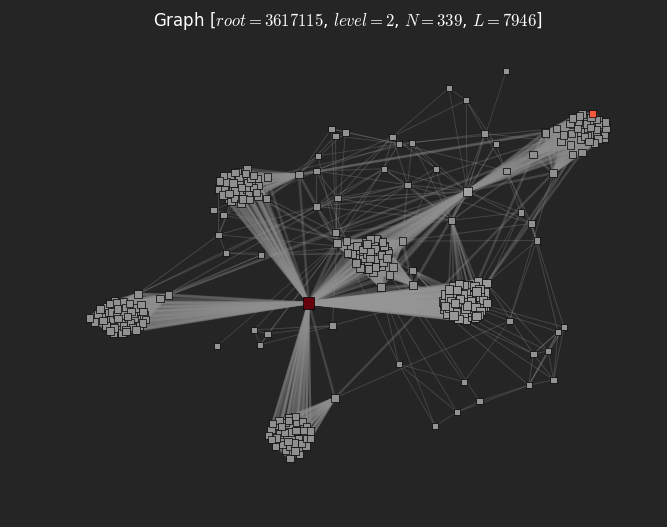

In [68]:
net.draw_graph_attr(
    A, 
    'birth_places', 
    {54: plt.cm.Reds},
    depth=2
)

In the graph above we see, that only a few Danes acted with other Danes together. Hence, birth places fail to represent communities in $A$. Next we will find real communities using `python-louvain` library.

In [69]:
communities_A = net.find_communities(A)


   Unique         M  Time (sec)
0     163  0.843944  553.691955



The algorithm detected 163 communities (2x more than in detected in $M$) with modularity $M=0.84$ (much higher than for $M$). Let us get a feel of newly calculated modularity by drawing a random graph.

In [70]:
net.attach_communities(A, communities_A)


     N      L  Components  Larg. component         C         p  k_min  k_max  \
0  619  24339           1              619  0.975183  0.127249      1    242   

   k_median     k_mean  Time (sec)  
0      78.0  78.639742    0.276104  

Attribute values: 0, -1


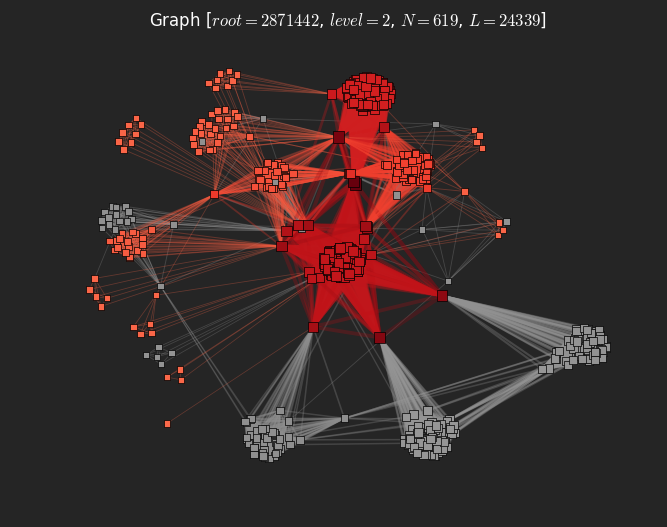

In [71]:
net.draw_graph_attr(
    A, 
    'communities', 
    {0: plt.cm.Reds},
    depth=2
)

Each coloured node (and edge) belong to community 0, and their colour depends upon degree. All grey-coloured nodes (and edges) belong to other communities. We can discover the almost perfect partition. We recognize it by the cardinality of links within nodes of the same community (strong boundaries of coloured sections) being higher than the cardinality of links to other communities, as communities are defined as groups of densely interconnected nodes that are only sparsely connected with the rest of the network.

In [72]:
nx.write_gpickle(A, './data/A')

## Summary

The main discoveries in this part of solution refer entirely to the **science fiction** genre. You are welcome to change the genre and test the infrastructure out. The statistics are based on data provided by IMDB. For details see the particular section.

### Statistics

* $172,650$ actors played in $13,989$ movies.
* Maximum $448$ actors acted in a movie.
* An actor played in maximum $48$ films.
* An actor acts in only $1.2$ movies on average, and vice versa.
* $82\%$ of movies and actors are connected, meaning if you get friends with an well-known actor, through a chain of actor-to-actor relationsships you may become friends with $82\%$ of all actors on the planet.
* Probability that a particular actor plays in a particular movie is $0.0014\%$.
* Probability that an actor plays in two random movies is $0.13\%$.
* Probability that a movie hires two random actors is $0.034\%$.
* An actor knows $59$ actors on average.
* There is an actor who played with $3052$ actors in total.
* A movie is connected through an actor to $18$ movies on average.
* Two random actors (or movies) are reached in a maximum of $14$ steps.
* Degrees of co-stardom network follow the powerlaw distribution, meaning the most common number of movies an actor plays is $1$, while the most common number of actors a movie hires is $2$.
* The most actors know fewer actors than those know on average.

### Centrality

* If you want to get friends with the most actors on Earth, first become friends with the cast of *Iron Man Three (2013)*, as it is the most central hub in the co-stardom network.
* Actors who played in *Kaze no tani no Naushika (1984)* played also in 343 different movies, which is a record.
* Actors who played in *Kidô senshi Gandamu (1981)* played also in very connected movies like *Kaze no tani no Naushika (1984)*.

### Attributes

* The science fiction genre has experienced the main gain in popularity in the beginning of $2000x$, when the technology for movie production evolutionized, and it goes through the peak right now.
*  The most common runtimes are around $10-30$ min and $80-120$ min.
* The most numbers of votes are low. But some movies have millions of them.
* The most movies are low-budget movies. The more budget the movie has, the more money it spends on cast and crew, and the more profitable actors it hires, which also play in many other pictures.
* The most actors of sci-fi films were born from 1950 to 1980. Actors who were born in later years are younger and therefore less wanted as more experienced actors. We also see a trend that the science fiction becomes more and more popular and many new actors join this trend. 
* Height attribute, in contrast, follows the normal (Gaussian) distribution, and isn't correlated with any other attribute.

### Assortativity

* Actors tend to play in movies which are released within a couple of years.
* Actors act preferentially in movies where the same language is spoken.
* Actors tend to act in movies produced in the same country.
* The most profitable actors act in the most expensive movies. But before they got very popular, they act in low-budget movies first.
* Actors tend to act both in short and long movies.
* Actors show no preference towards some particular production company or director.
* Actors of similar age tend to play in movies. This seems to be well reasoned: there are movies where teens play the central role, movies with young adults, and finally adults. 
* Actors who were born in same country tend to act together. 
* Well-known actors tend to act with other well-known actors. 
* Height hasn't any impact on decisions of companies to hire somebody or not.

### Communities

* Production countries, release years, and languages are not good communities, that is for example, movies made within USA are interconnected only moderately, while they share many connections with movies made outside of USA. Film industry is an international industry.
* None of the actor-related attributes build good communities, in particular, for attribute birth place it means that actors act with international actors very commonly, while for attribute birth year it means that teens commonly play with adults, and vice versa. 
* The communities detected by an algorithm are much better than those of attributes.